# Machine Learning Model Analysis

The purpose of this analysis is to provide the best machine learning model for Black Rock to predict the likihood if tomorrow's closing price being higher or lower than today's closing price

I am going to use Black rock's maximum of data available to train and test the model

In [1]:
# Importing Libraries
# Data Handling
import pandas as pd
import numpy as np
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as mtick
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)# Financial Data Analysis
import yfinance as yf
import ta
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Models
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier # Hiding warnings
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Loading BlackRock stocks until Aug 29th, 2023
blk = yf.download('BLK', end = '2023-08-29')
blk

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-10-01,14.000000,14.250000,14.000000,14.125000,8.955748,3162400
1999-10-04,14.125000,14.125000,14.000000,14.000000,8.876494,533400
1999-10-05,14.000000,14.125000,14.000000,14.125000,8.955748,270600
1999-10-06,14.125000,14.875000,14.125000,14.875000,9.431273,205400
1999-10-07,14.875000,14.875000,14.062500,14.125000,8.955748,214200
...,...,...,...,...,...,...
2023-08-22,671.590027,674.760010,664.609985,665.840027,665.840027,332500
2023-08-23,668.400024,680.330017,667.119995,678.770020,678.770020,386800
2023-08-24,678.780029,688.580017,672.969971,673.159973,673.159973,317900


In [3]:
open_data = blk['Open']
high_data = blk['High']
low_data = blk['Low']
close_data = blk['Close']
dates = blk.index  

trace = go.Candlestick(x=dates,
                open=open_data,
                high=high_data,
                low=low_data,
                close=close_data)

layout = go.Layout(
    title='BlackRock Stock Price (Candlestick)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price (in USD)'),
    plot_bgcolor='rgba(230, 230, 230, 0.8)',  # Setting a background color for better clarity
)

fig = go.Figure(data=[trace], layout=layout)


fig.show()


In [4]:
# Data Splitting
train = blk[blk.index.year <= 2010] 
test = blk[blk.index.year >= 2011]

In [5]:
# Adding Close_Shift Variable
train['Close_Shift'] = train['Adj Close'].shift(1) 
test['Close_Shift'] = test['Adj Close'].shift(1)

In [6]:
# Adding Daily Returns variable
train['Return'] = (train['Adj Close']/train['Close_Shift'] - 1) * 100 
test['Return'] = (test['Adj Close']/test['Close_Shift'] - 1) * 100

In [7]:
# Creating target variable on both datasets
train['target'] = np.where(train['Return'].shift(-1) > 0, 1, 0) 
test['target'] = np.where(test['Return'].shift(-1) > 0, 1, 0)

In [8]:
X_train = train.drop('target', axis = 1)  # Selecting Predictor Variables
y_train = train['target']  # Selecting Target Variable

X_test = test.drop('target', axis = 1)  # Selecting Predictor Variables
y_test = test['target']  # Selecting Target Variable

In [9]:
# Defining feature engineering function
def feature_engineering(df):
# Adding Simple Moving Averages
    df['sma5'] = ta.trend.sma_indicator(df['Adj Close'],window = 5) 
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'],window = 10) 
    df['sma15'] = ta.trend.sma_indicator(df['Adj Close'],window = 15) 
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'],window = 20) 
    df['sma30'] = ta.trend.sma_indicator(df['Adj Close'],window = 30) 
    df['sma50'] = ta.trend.sma_indicator(df['Adj Close'],window = 50) 
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'],window = 80) 
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'],window = 100) 
    df['sma200'] = ta.trend.sma_indicator(df['Adj Close'],window = 200)
    # Adding Price to Simple Moving Averages ratios
    df['sma5_ratio'] = df['Adj Close'] / df['sma5'] 
    df['sma10_ratio'] = df['Adj Close'] / df['sma10'] 
    df['sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['sma30_ratio'] = df['Adj Close'] / df['sma30'] 
    df['sma50_ratio'] = df['Adj Close'] / df['sma50'] 
    df['sma80_ratio'] = df['Adj Close'] / df['sma80'] 
    df['sma100_ratio'] = df['Adj Close'] / df['sma100'] 
    df['sma200_ratio'] = df['Adj Close'] / df['sma200']

    # Adding RSI, CCI, Bollinger Bands, and OBV
    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.volatility.BollingerBands(df['Adj Close'])
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
    # Adding features derived from the indicators above
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int) 
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int) 
    df['above_bb_high'] = (df['Adj Close'] >= df['bb_high']).astype(int) 
    df['below_bb_low'] = (df['Adj Close'] <= df['bb_low']).astype(int)
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close' ].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close' ].diff().rolling(20).sum()
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int) 
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int) 
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int) 
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int) 
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int) 
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int) 
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)
    # Removing NaN values from the dataframe
    df.dropna(inplace = True) 
    return df

In [10]:
# Applying function to the X_train and X_test sets
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [11]:
# Removing from y_train and y_test the NaN values that were dropped from X_train and X_t est by the index
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [12]:
# Creating a list of different classification models
classifiers = [
    LogisticRegression(random_state = 42), 
    XGBClassifier(random_state = 42), 
    LGBMClassifier(random_state = 42), 
    CatBoostClassifier(random_state = 42, verbose = False), 
    AdaBoostClassifier(random_state = 42), 
    RandomForestClassifier(random_state = 42)
]
# Iterating over classifiers in the list above, training, and evaluating them
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred) 
    print(f'{type(clf).__name__}: AUC Score={auc_score:.3f}')

LogisticRegression: AUC Score=0.501
XGBClassifier: AUC Score=0.517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1331, number of negative: 1301
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8188
[LightGBM] [Info] Number of data points in the train set: 2632, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505699 -> initscore=0.022797
[LightGBM] [Info] Start training from score 0.022797
LGBMClassifier: AUC Score=0.502
CatBoostClassifier: AUC Score=0.503
AdaBoostClassifier: AUC Score=0.515
RandomForestClassifier: AUC Score=0.502


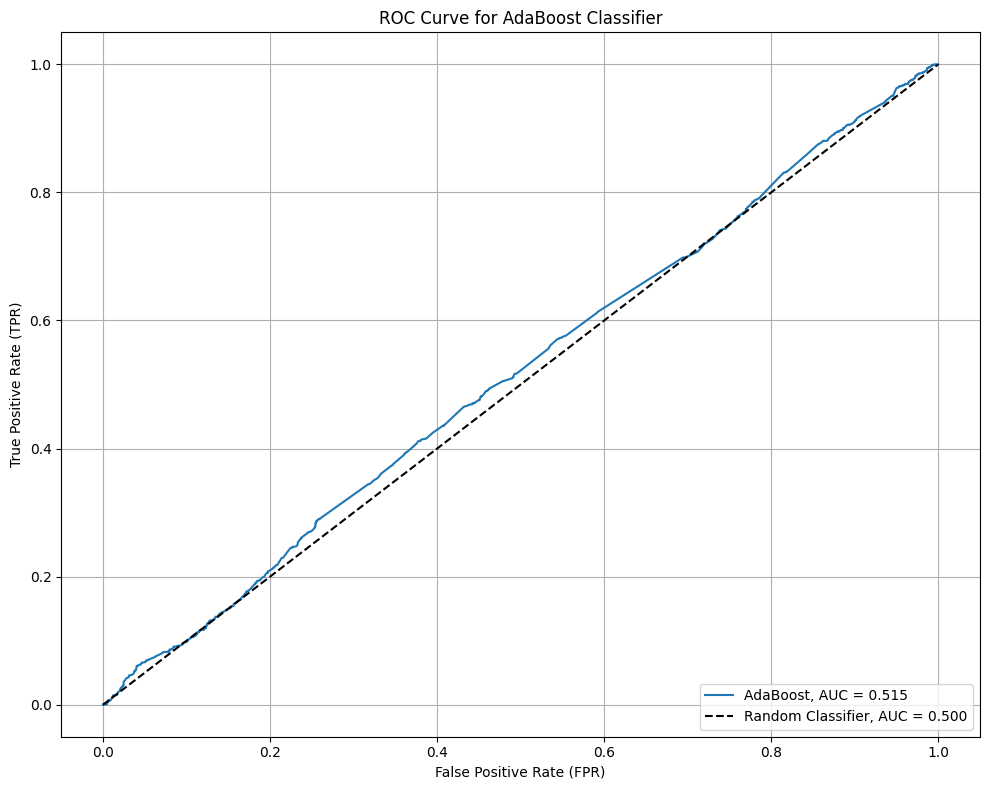

In [13]:
# Train AdaBoostClassifier and get the probabilities for the positive class
clf = AdaBoostClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label=f"AdaBoost, AUC = {auc(fpr, tpr):.3f}")
plt.plot([0,1], [0,1], 'k--', label="Random Classifier, AUC = 0.500")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for AdaBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


AUC = 0.5: This suggests no discrimination, which means the model's prediction is no better than random guessing. It's akin to flipping a coin. In your results, LogisticRegression and RandomForestClassifier have AUCs very close to 0.5, suggesting they're not providing any meaningful discrimination for the dataset you've provided.

0.5 < AUC < 1: This indicates some discrimination power, with higher values being better. An AUC of 1 indicates a perfect classifier, where it can perfectly separate the two classes. In practice, an AUC score above 0.8 or 0.9 is considered excellent. In your results, none of the models achieved a high AUC. The highest AUC you have is from AdaBoostClassifier with an AUC of 0.515, which suggests very minimal predictive power beyond random guessing.

AUC < 0.5: Technically, this indicates a model that's doing worse than random guessing. However, you can invert its predictions to achieve an AUC greater than 0.5. In most real-world applications, an AUC less than 0.5 indicates that something may be wrong with the data preprocessing or the way the model is trained.

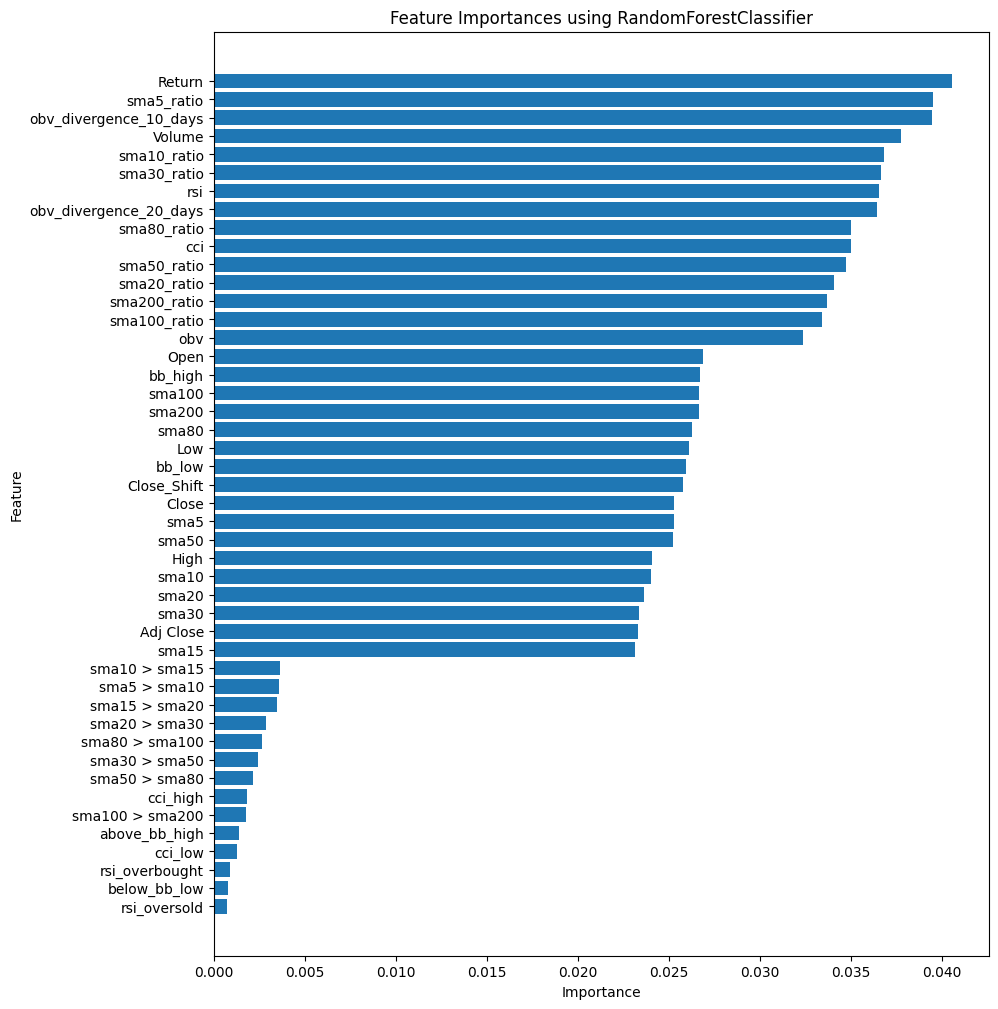

In [14]:
# Train a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Get the indices of the sorted feature importances
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances using RandomForestClassifier')
plt.show()


In [15]:
y_pred

array([0.48, 0.52, 0.48, ..., 0.31, 0.33, 0.25])

In [16]:
quantile_intervals = np.arange(0, 1.125, 0.125) # Creating intervals for the quantiles 
quantile_values = np.quantile(y_pred, quantile_intervals) # Dividing y_pred in 8 different quantiles

classes = pd.cut(y_pred, quantile_values) # Grouping probabilities according to the quantiles
X_test['y_true'] = y_test # Creating a new column in the X_test set containing the true label values
table = pd.crosstab(classes, X_test['y_true']) # Creating a table counting true labels according to each probability range

print(table)

y_true          0    1
row_0                 
(0.08, 0.16]  208  200
(0.16, 0.2]   177  224
(0.2, 0.24]   182  195
(0.24, 0.27]  173  179
(0.27, 0.3]   166  210
(0.3, 0.34]   183  212
(0.34, 0.4]   156  160
(0.4, 0.73]   175  184


In [17]:
sign = np.zeros_like(y_pred) # Creating an array with 0s in the same length as y_pred
# Short selling signal
sign[((y_pred >= 0.3477) & (y_pred < 0.5087)) | ((y_pred > 0.5189) & (y_pred < 0.5195) )] = -1
# Buying signal
sign[((y_pred >= 0.5087) & (y_pred <= 0.5189)) |
((y_pred >= 0.5195) & (y_pred <= 0.5252))] = 1
# Display signal values
sign

array([-1.,  1., -1., ...,  0.,  0.,  0.])

In [18]:
X_test['sign'] = sign # Creating new ‘sign’ column
X_test['position'] = X_test['sign'].shift(1) # Creating 'position' attribute X_test['model_returns'] = X_test['position'] * X_test['Return'] # Creating 'daily retu rns' attribute for the strategy
X_test.head(8) # Displaying X_test set

,Open,High,Low,Close,Adj Close,Volume,Close_Shift,Return,sma5,sma10,...,sma10 > sma15,sma15 > sma20,sma20 > sma30,sma30 > sma50,sma50 > sma80,sma80 > sma100,sma100 > sma200,y_true,sign,position
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-17,154.250000,155.369995,150.250000,150.729996,110.976662,619700,114.790527,-3.322457,113.288535,112.039834,...,1,1,0,0,0,0,0,1,-1.0,NaN
2011-10-18,151.020004,157.759995,150.279999,156.300003,115.077644,1155200,110.976662,3.695356,113.765633,112.709829,...,1,1,0,0,0,0,0,0,1.0,-1.0
2011-10-19,153.000000,154.000000,148.059998,148.919998,109.644081,1540800,115.077644,-4.721650,112.723093,112.594241,...,1,1,0,0,0,0,0,1,-1.0,1.0
2011-10-20,149.039993,153.509995,146.529999,152.160004,112.029518,1160300,109.644081,2.175619,112.503687,112.630317,...,1,1,0,0,0,0,0,1,-1.0,-1.0
2011-10-21,154.509995,155.750000,152.149994,154.320007,113.619896,941300,112.029518,1.419606,112.269560,113.111837,...,1,1,0,0,0,0,0,1,0.0,-1.0
2011-10-24,155.699997,158.339996,154.130005,157.479996,115.946419,776400,113.619896,2.047637,113.263512,113.276023,...,1,1,0,0,0,0,0,0,0.0,0.0
2011-10-25,158.229996,158.229996,149.929993,150.380005,110.718979,915900,115.946419,-4.508496,112.391779,113.078706,...,1,1,0,0,0,0,0,1,1.0,0.0
2011-10-26,153.229996,155.250000,151.419998,154.369995,113.656700,963700,110.718979,2.653313,113.194302,112.958698,...,1,1,0,0,0,0,0,1,-1.0,1.0


In [21]:
print(X_test.columns)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Close_Shift',
       'Return', 'sma5', 'sma10', 'sma15', 'sma20', 'sma30', 'sma50', 'sma80',
       'sma100', 'sma200', 'sma5_ratio', 'sma10_ratio', 'sma20_ratio',
       'sma30_ratio', 'sma50_ratio', 'sma80_ratio', 'sma100_ratio',
       'sma200_ratio', 'rsi', 'cci', 'bb_high', 'bb_low', 'obv',
       'rsi_overbought', 'rsi_oversold', 'above_bb_high', 'below_bb_low',
       'obv_divergence_10_days', 'obv_divergence_20_days', 'cci_high',
       'cci_low', 'sma5 > sma10', 'sma10 > sma15', 'sma15 > sma20',
       'sma20 > sma30', 'sma30 > sma50', 'sma50 > sma80', 'sma80 > sma100',
       'sma100 > sma200', 'y_true', 'sign', 'position',
       'cumulative_stock_returns'],
      dtype='object')


In [24]:
print(set(X_train.columns) - set(X_test.columns))

print(set(X_test.columns) - set(X_train.columns))


set()
{'sign', 'cumulative_stock_returns', 'y_true', 'position'}


In [25]:
extra_columns = {'sign', 'cumulative_stock_returns', 'y_true', 'position'}
X_test.drop(extra_columns, axis=1, inplace=True)

xgb = XGBClassifier()

# Fit the model on training data (assuming you have X_train and y_train ready)
xgb.fit(X_train, y_train)

X_test['model_returns'] = xgb.predict(X_test)


In [26]:
X_test['cumulative_stock_returns'] = (1 + X_test['Return'] / 100).cumprod()
X_test['cumulative_model_returns'] = (1 + X_test['model_returns'] / 100).cumprod()


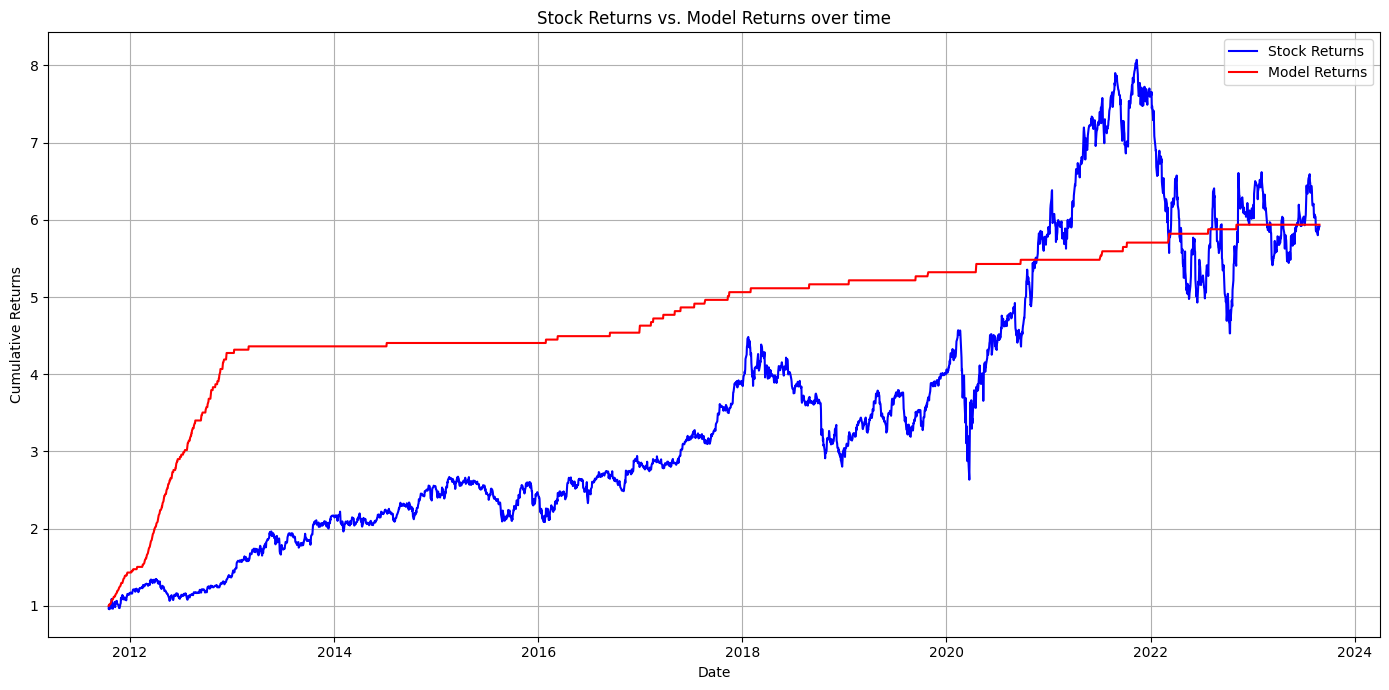

In [27]:
# Now, let's visualize it using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(X_test.index, X_test['cumulative_stock_returns'], label='Stock Returns', color='blue')
plt.plot(X_test.index, X_test['cumulative_model_returns'], label='Model Returns', color='red')
plt.title('Stock Returns vs. Model Returns over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()